In [1]:
from __future__ import annotations

"""
Initialize a model and SAE.
"""
from transformers import AutoModelForCausalLM, AutoTokenizer
from sae_lens import SAE  # pip install sae-lens
import torch

torch.set_grad_enabled(False)
with torch.no_grad():
    model = AutoModelForCausalLM.from_pretrained(
        "google/gemma-2-2b",
        device_map="cuda",
    )
    tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")
    sae, cfg_dict, sparsity = SAE.from_pretrained(
        release="gemma-scope-2b-pt-res-canonical",
        sae_id="layer_20/width_16k/canonical",
    )
    sae.cuda()
    sae.eval()
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
        p.grad = None
    for p in sae.parameters():
        p.requires_grad = False
        p.grad = None

from transformer_lens.utils import tokenize_and_concatenate
from datasets import load_dataset

dataset_name = "stas/openwebtext-10k"  # yolo
dataset = load_dataset(
    dataset_name, split="train", trust_remote_code=True
)  # Smaller version
tokens = tokenize_and_concatenate(
    dataset=dataset,  # type: ignore
    tokenizer=tokenizer,  # type: ignore
    streaming=True,
    # NOTE: all these have context 128
    max_length=128,  # sae.cfg.context_size,
    add_bos_token=True,  # sae.cfg.prepend_bos,
)["tokens"]
tokens = tokens.to("cuda")  # eh

/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


In [2]:
"""
Collect some output activations.
"""

try:
    del collected_outputs
except:
    pass
import gc

gc.collect()
torch.cuda.empty_cache()
import tqdm

collected_outputs = []
less_tokens = tokens[:10_000]  # eh


def gather_target_act_hook(mod, inputs, outputs):
    global collected_outputs
    assert isinstance(outputs, tuple)
    assert len(outputs) == 1 and isinstance(outputs[0], torch.Tensor), f"Expected a single tensor output, got {outputs}" # fmt: skip
    collected_outputs.append(outputs[0].detach().requires_grad_(False).cpu())
    return outputs


handle = model.model.layers[20].register_forward_hook(gather_target_act_hook)
try:
    batch_size = 100
    for i in tqdm.trange(0, less_tokens.shape[0], batch_size):
        j = min(i + batch_size, less_tokens.shape[0])
        model.forward(less_tokens[i:j])
finally:
    handle.remove()
collected_outputs = torch.cat(collected_outputs, dim=0)
print(collected_outputs.shape)

100%|██████████| 100/100 [04:25<00:00,  2.66s/it]


torch.Size([10000, 128, 2304])


In [3]:
tokens_is_special = (
    (less_tokens == tokenizer.bos_token_id)
    | (less_tokens == tokenizer.eos_token_id)
    | (less_tokens == tokenizer.pad_token_id)
)
tokens_is_special_flat = tokens_is_special.cpu().flatten()
collected_outputs_flat = collected_outputs.cpu().reshape(
    -1, collected_outputs.shape[-1]
)
activations = collected_outputs_flat[~tokens_is_special_flat, :]
print(activations.shape)  # These are the ones we will use to understand our SAE

torch.Size([1268749, 2304])


In [4]:
from jaxtyping import Float
from torch import Tensor
from typing import Tuple, List


def calculate_pca(
    activations: Float[Tensor, "n_samples n_features"], use_cuda: bool = False
) -> Tuple[Float[Tensor, "n_components n_features"], Float[Tensor, "n_features"]]:
    """
    Return:
    1. The PCA rotation matrix.
    2. The eigenvalues.
    3. The mean of the activations.
    """
    # Center the data
    device = activations.device
    if use_cuda:
        activations = activations.cuda()
    activations_mean = activations.mean(dim=0, keepdim=True)
    activations = activations - activations_mean

    # Calculate covariance matrix
    n_samples = activations.shape[0]
    cov_matrix = torch.matmul(activations.T, activations) / (n_samples - 1)

    # Get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)

    # Sort eigenvectors by eigenvalues in descending order
    idx = torch.argsort(eigenvalues, descending=True)
    eigenvectors = eigenvectors[:, idx]
    return (
        eigenvectors.to(device),
        eigenvalues.to(device),
        activations_mean.flatten().to(device),
    )


def apply_pca(
    activations: Float[Tensor, "n_samples n_features"],
    pca_mean: Float[Tensor, "n_features"],
    pca_components: Float[Tensor, "n_components n_features"],
    component_idxs: List[int],
    use_cuda: bool = False,
) -> Float[Tensor, "n_samples n_components"]:
    activations_device = activations.device
    pca_mean_device = pca_mean.device
    pca_components_device = pca_components.device
    if use_cuda:
        activations = activations.cuda()
        pca_mean = pca_mean.cuda()
        pca_components = pca_components.cuda()
    component_idxs = torch.tensor(component_idxs)
    centered_activations = activations - pca_mean
    projected = torch.matmul(centered_activations, pca_components[:, component_idxs])
    # So now we've taken the dot product and it's time to normalize
    # project V onto direction W means take (V dot W) / |W||V| * |V| * W / |W|
    # but we want the magnitude which is (V dot W) / |W| => just divide by the norm of W
    # (which SHOULD be 1 here but just in case...)
    Ws = pca_components[:, component_idxs].norm(dim=0)
    # activations = activations.to(activations_device) # I don't think this really matters?
    # pca_mean = pca_mean.to(pca_mean_device)
    # pca_components = pca_components.to(pca_components_device)
    return (projected / Ws).to(activations_device)


# Get the first two components
activations_proj, activations_val, activations_mean = calculate_pca(activations[:3000])
activations_proj_2d = apply_pca(
    activations[:3000], activations_mean, activations_proj, [0, 1]
)
print(activations_proj_2d.shape)
import gc
try:
    del activations_proj_2d
except:
    pass
try:
    del activations_proj
except:
    pass
try:
    del activations_val
except:
    pass
gc.collect()
torch.cuda.empty_cache()


torch.Size([3000, 2])


In [5]:
activations_proj, activations_val, activations_mean = calculate_pca(
    activations[:], use_cuda=True
)

In [6]:
activations_proj_2d_01 = apply_pca(
    activations[:], activations_mean, activations_proj, [0, 1]
)
activations_proj_2d_12 = apply_pca(
    activations[:], activations_mean, activations_proj, [1, 2]
)
activations_proj_2d_02 = apply_pca(
    activations[:], activations_mean, activations_proj, [0, 2]
)
print(activations_proj_2d_01.shape)
print(activations_proj_2d_12.shape)
print(activations_proj_2d_02.shape)

torch.Size([1268749, 2])
torch.Size([1268749, 2])
torch.Size([1268749, 2])


In [11]:
"""
Utils to not OOM?
"""
# Code to visualize CUDA memory usage
import torch
import gc
import pandas as pd
from IPython.display import display

# Force garbage collection
gc.collect()

# Get current CUDA memory stats
def get_cuda_memory_usage(save_to="cuda_memory_usage.txt"):
    """Improved CUDA memory usage tracker with recursive module inspection"""
    torch.cuda.synchronize()  # Make sure all CUDA operations are completed
    
    # Get memory stats
    allocated = torch.cuda.memory_allocated() / (1024 ** 3)  # Convert to GB
    reserved = torch.cuda.memory_reserved() / (1024 ** 3)    # Convert to GB
    
    print(f"CUDA Memory: {allocated:.2f} GB allocated, {reserved:.2f} GB reserved")
    
    # Get per-tensor memory usage
    objects = []
    
    def process_tensor(tensor, name="Unknown", parent=""):
        """Process a single tensor and add it to objects list"""
        if tensor.device.type == 'cuda':
            full_name = f"{parent}.{name}" if parent else name
            objects.append({
                'variable_name': full_name,
                'type': type(tensor).__name__,
                'shape': tuple(tensor.shape),
                'size_mb': tensor.element_size() * tensor.nelement() / (1024 ** 2),
                'device': str(tensor.device)
            })
    
    def recurse_module(module, parent_name=""):
        """Recursively process nn.Module objects and their parameters/buffers"""
        for name, param in module.named_parameters(recurse=False):
            process_tensor(param, name, parent_name)
        
        for name, buf in module.named_buffers(recurse=False):
            process_tensor(buf, name, parent_name)
            
        for name, child in module.named_children():
            child_name = f"{parent_name}.{name}" if parent_name else name
            recurse_module(child, child_name)
    
    # First check all objects in memory
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                # For standalone tensors
                try:
                    name = getattr(obj, 'name', "unnamed_tensor")
                except:
                    name = "unnamed_tensor"
                process_tensor(obj, name)
            elif isinstance(obj, torch.nn.Module):
                # For modules, we'll process them separately with the recursive function
                try:
                    module_name = obj.__class__.__name__
                    recurse_module(obj, module_name)
                except:
                    pass
        except:
            pass
    
    # Sort by size (largest first)
    objects = sorted(objects, key=lambda x: x['size_mb'], reverse=True)
    
    # Display as a table
    if objects:
        df = pd.DataFrame(objects)
        print(f"\nFound {len(objects)} tensors on CUDA")
        display(df)
        with open(save_to, "w") as f:
            f.write(df.to_string())
    else:
        print("No tensors found on CUDA")
        
    # Print GPU memory by device
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_properties(i).name}")
        print(f"  Memory allocated: {torch.cuda.memory_allocated(i) / (1024**3):.2f} GB")
        print(f"  Memory reserved: {torch.cuda.memory_reserved(i) / (1024**3):.2f} GB")
        print(f"  Max memory allocated: {torch.cuda.max_memory_allocated(i) / (1024**3):.2f} GB")

# Run the memory usage check
get_cuda_memory_usage`(save_to="cuda_memory_usage.txt")

CUDA Memory: 10.14 GB allocated, 33.72 GB reserved

Found 1925 tensors on CUDA


/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/torch/__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
/tmp/ipykernel_3961924/3375580987.py:61: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  elif isinstance(obj, torch.nn.Module):


,variable_name,type,shape,size_mb,device
0,Gemma2ForCausalLM.model.embed_tokens.weight,Parameter,"(256000, 2304)",2250.000000,cuda:0
1,Gemma2ForCausalLM.lm_head.weight,Parameter,"(256000, 2304)",2250.000000,cuda:0
2,Linear.weight,Parameter,"(256000, 2304)",2250.000000,cuda:0
3,None,Parameter,"(256000, 2304)",2250.000000,cuda:0
4,Gemma2Model.embed_tokens.weight,Parameter,"(256000, 2304)",2250.000000,cuda:0
...,...,...,...,...,...
1920,None,Parameter,"(2304,)",0.008789,cuda:0
1921,Gemma2ForCausalLM.model.rotary_emb.inv_freq,Tensor,"(128,)",0.000488,cuda:0
1922,Gemma2Model.rotary_emb.inv_freq,Tensor,"(128,)",0.000488,cuda:0
1923,Gemma2RotaryEmbedding.inv_freq,Tensor,"(128,)",0.000488,cuda:0


GPU 0: NVIDIA H100 PCIe
  Memory allocated: 10.14 GB
  Memory reserved: 33.72 GB
  Max memory allocated: 37.20 GB


In [12]:
# You should see usage drop here :)
import gc
del model
gc.collect()
torch.cuda.empty_cache()

In [13]:
# TODO(Adriano) review this AI slop for with_cuda
# # You should see usage drop here :)
# class CudaContextManager:
#     """
#     Context manager that temporarily moves tensors to CUDA for operations,
#     then returns results to their original devices.
    
#     Example:
#         with CudaContextManager():
#             z = x * y  # Operation performed on CUDA, result returned to original device
#     """
#     def __init__(self, cuda_device="cuda:0"):
#         self.cuda_device = cuda_device
#         self.tensors_and_devices = []
    
#     def __enter__(self):
#         # Monkey patch torch.Tensor operations to track and move tensors
#         self._original_tensor_init = torch.Tensor.__init__
        
#         def _patched_tensor_init(tensor_self, *args, **kwargs):
#             self._original_tensor_init(tensor_self, *args, **kwargs)
#             if tensor_self.device.type != 'cuda':
#                 original_device = tensor_self.device
#                 self.tensors_and_devices.append((tensor_self, original_device))
#                 tensor_self.data = tensor_self.data.to(self.cuda_device)
        
#         torch.Tensor.__init__ = _patched_tensor_init
#         return self
    
#     def __exit__(self, exc_type, exc_val, exc_tb):
#         # Restore original tensor init
#         torch.Tensor.__init__ = self._original_tensor_init
        
#         # Move tensors back to their original devices
#         for tensor, original_device in self.tensors_and_devices:
#             if tensor.device.type == 'cuda':
#                 tensor.data = tensor.data.to(original_device)

# def with_cuda(cuda_device="cuda:0"):
#     """
#     Convenience function to create a CudaContextManager.
    
#     Example:
#         with with_cuda():
#             z = x * y  # Operation performed on CUDA, result returned to original device
#     """
#     return CudaContextManager(cuda_device=cuda_device)


NameError: name 'model' is not defined

Model not found (probably already deleted tbh)


Plotting 2D histograms: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


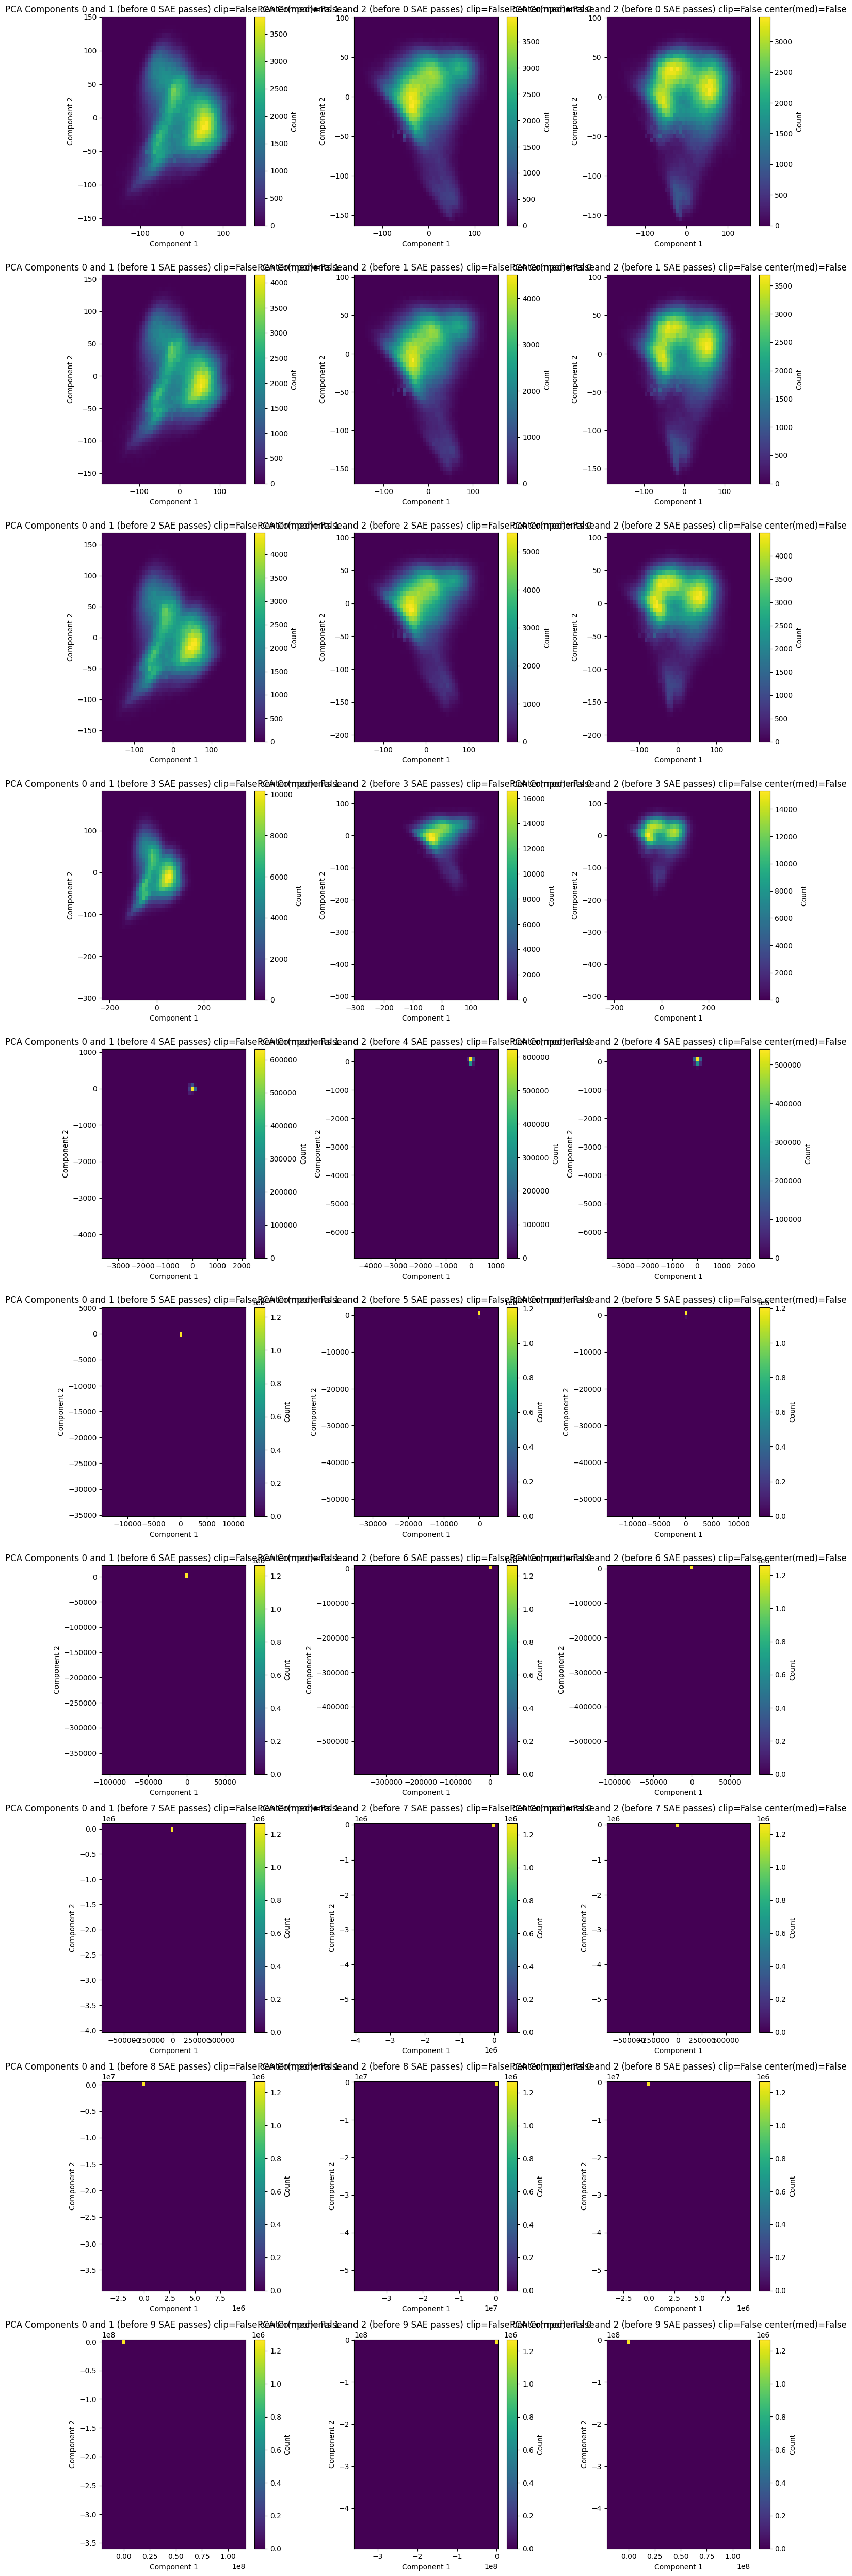

Plotting 2D histograms: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


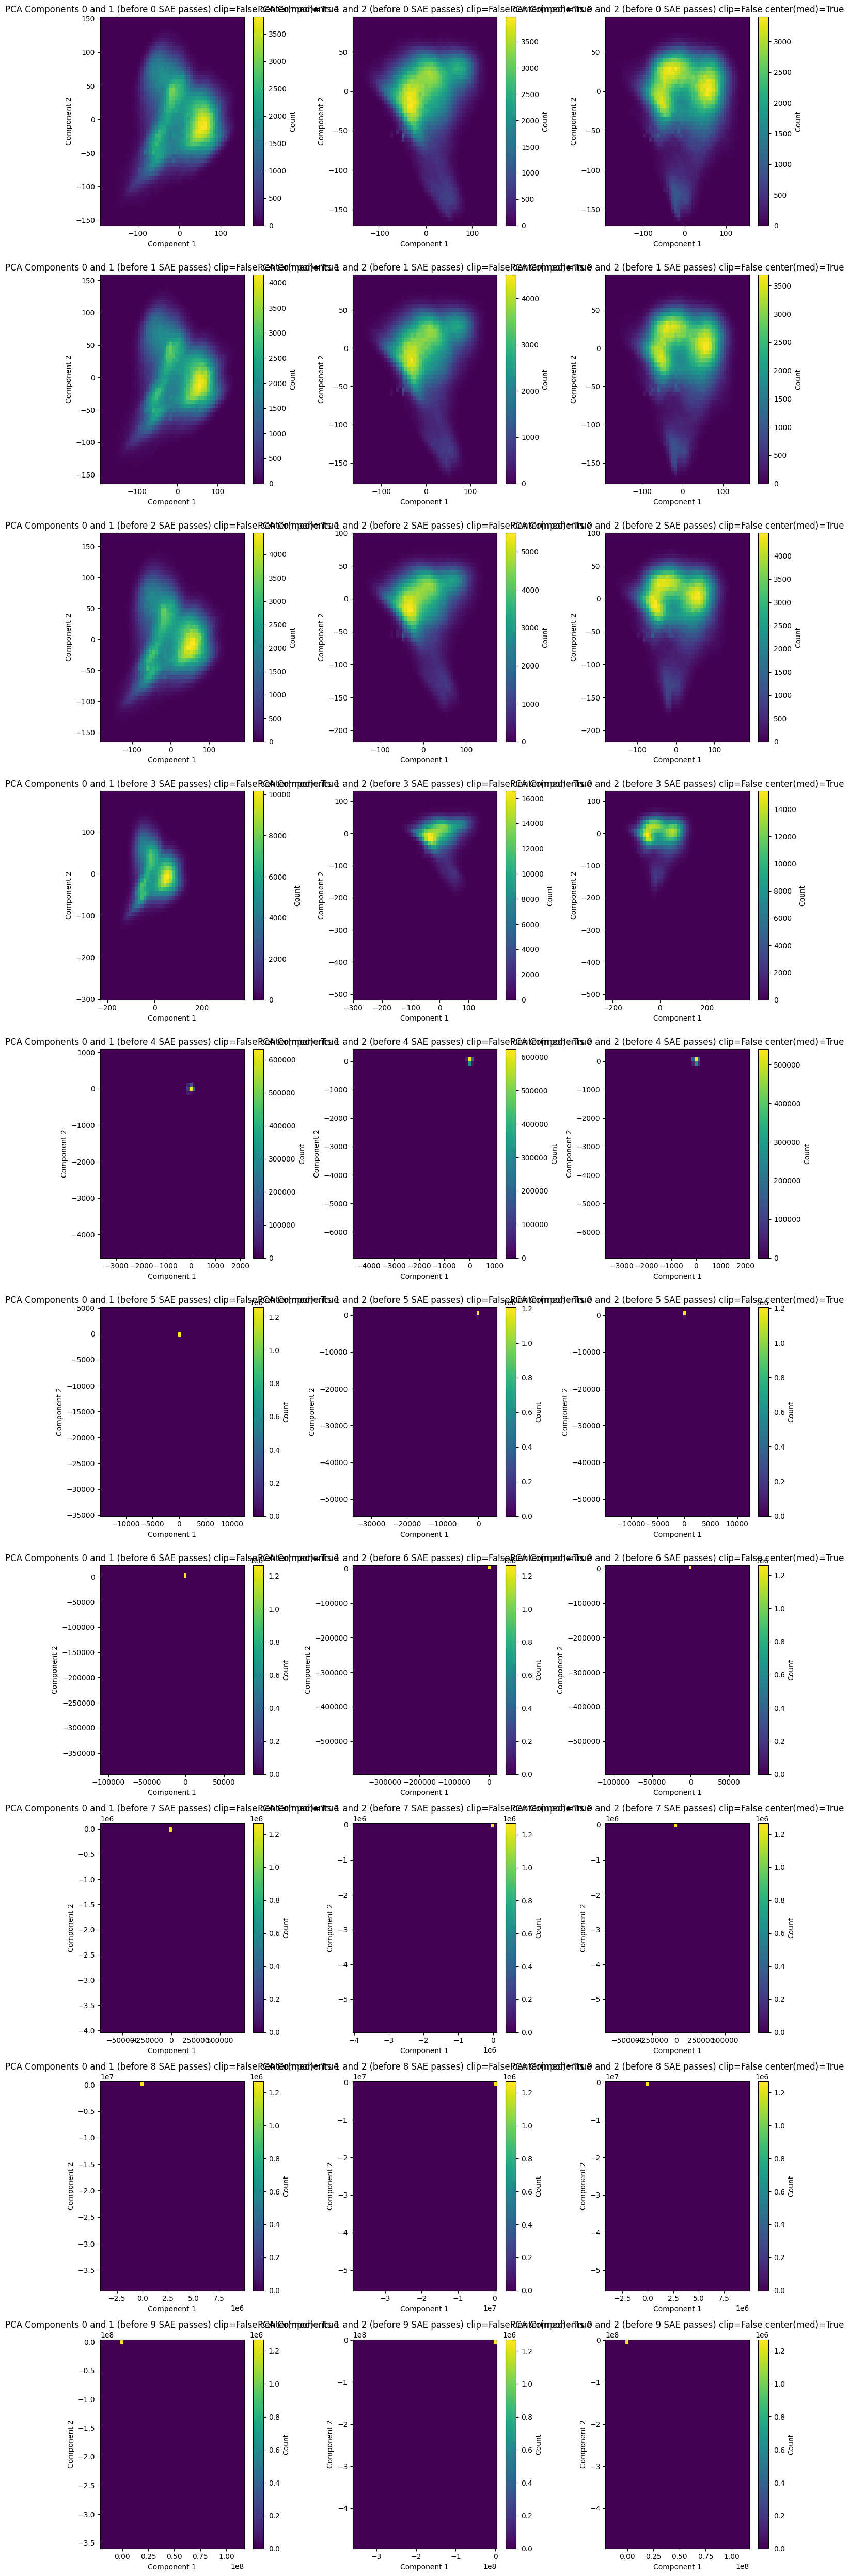

Plotting 2D histograms: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


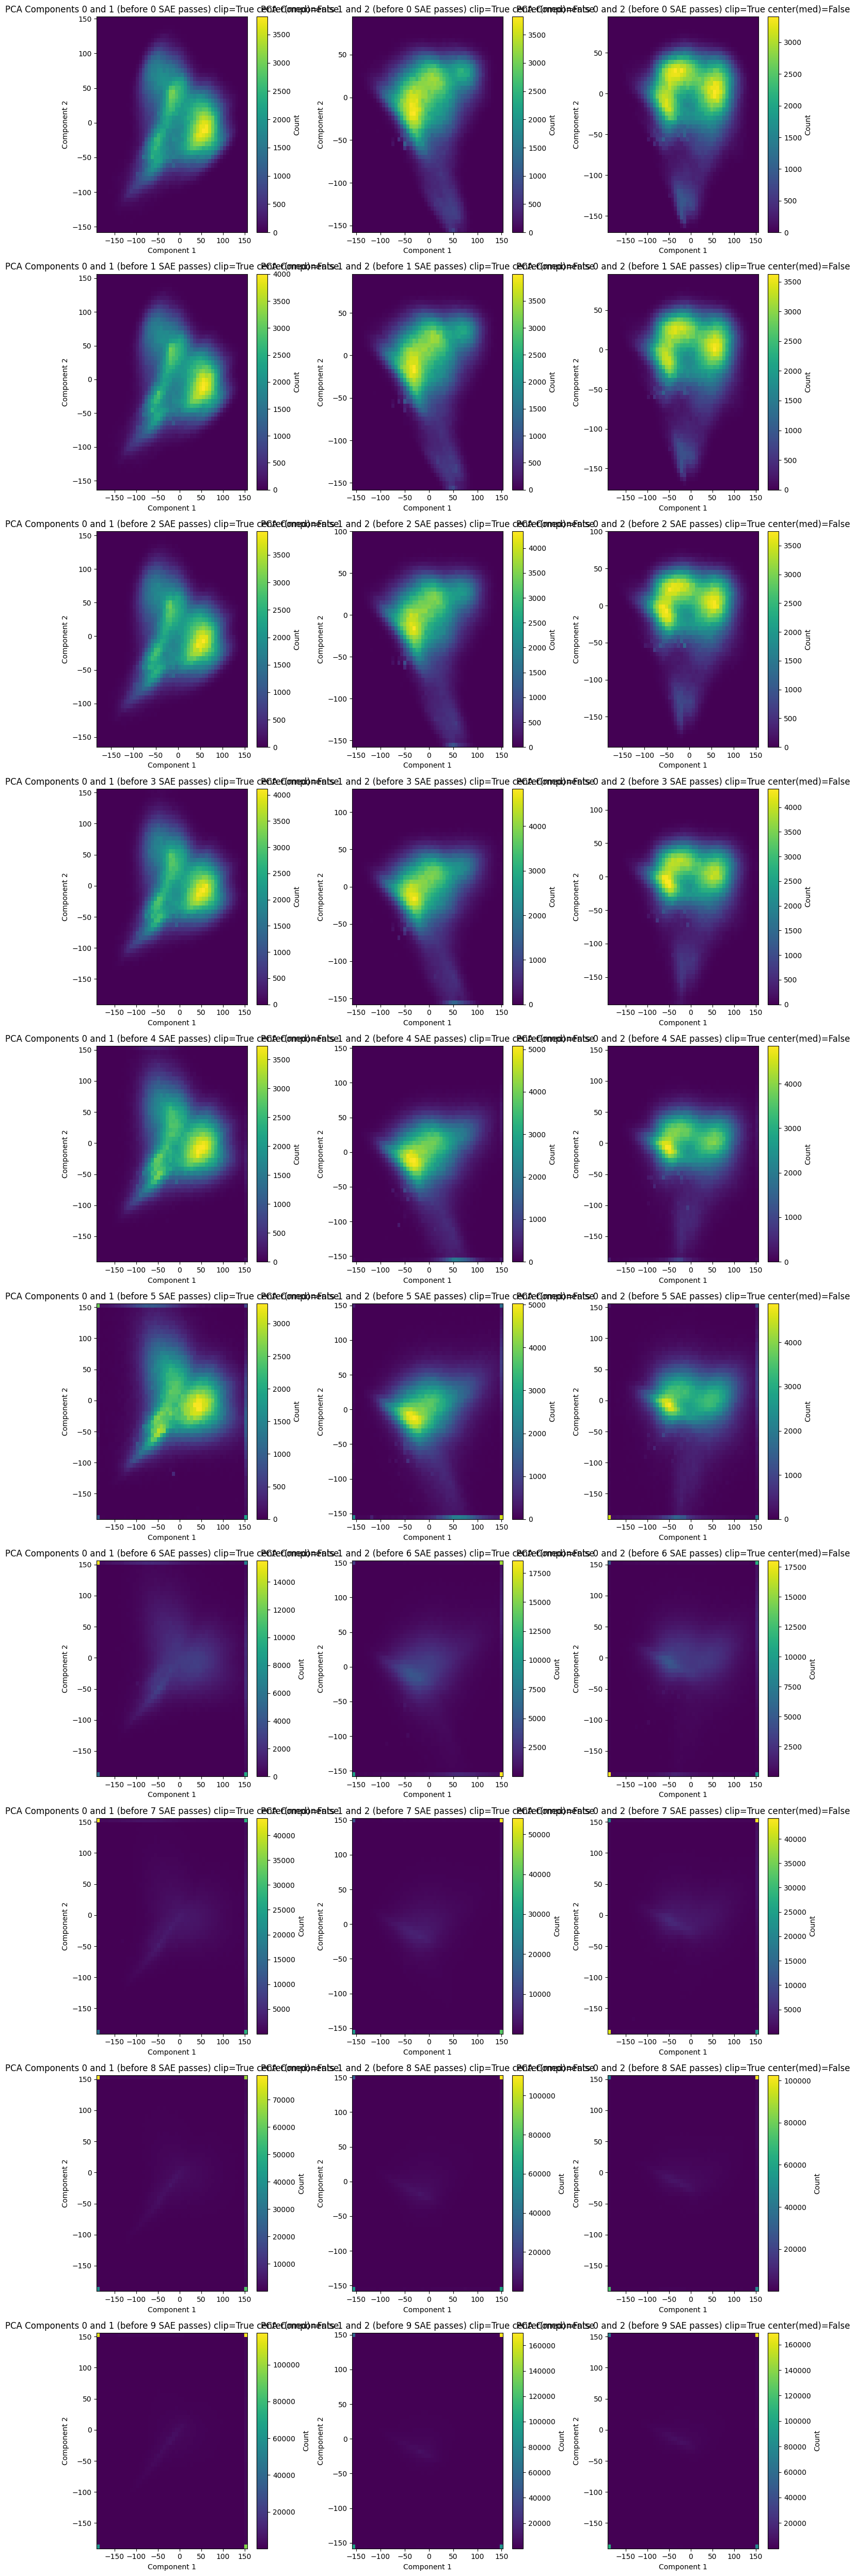

Plotting 2D histograms: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


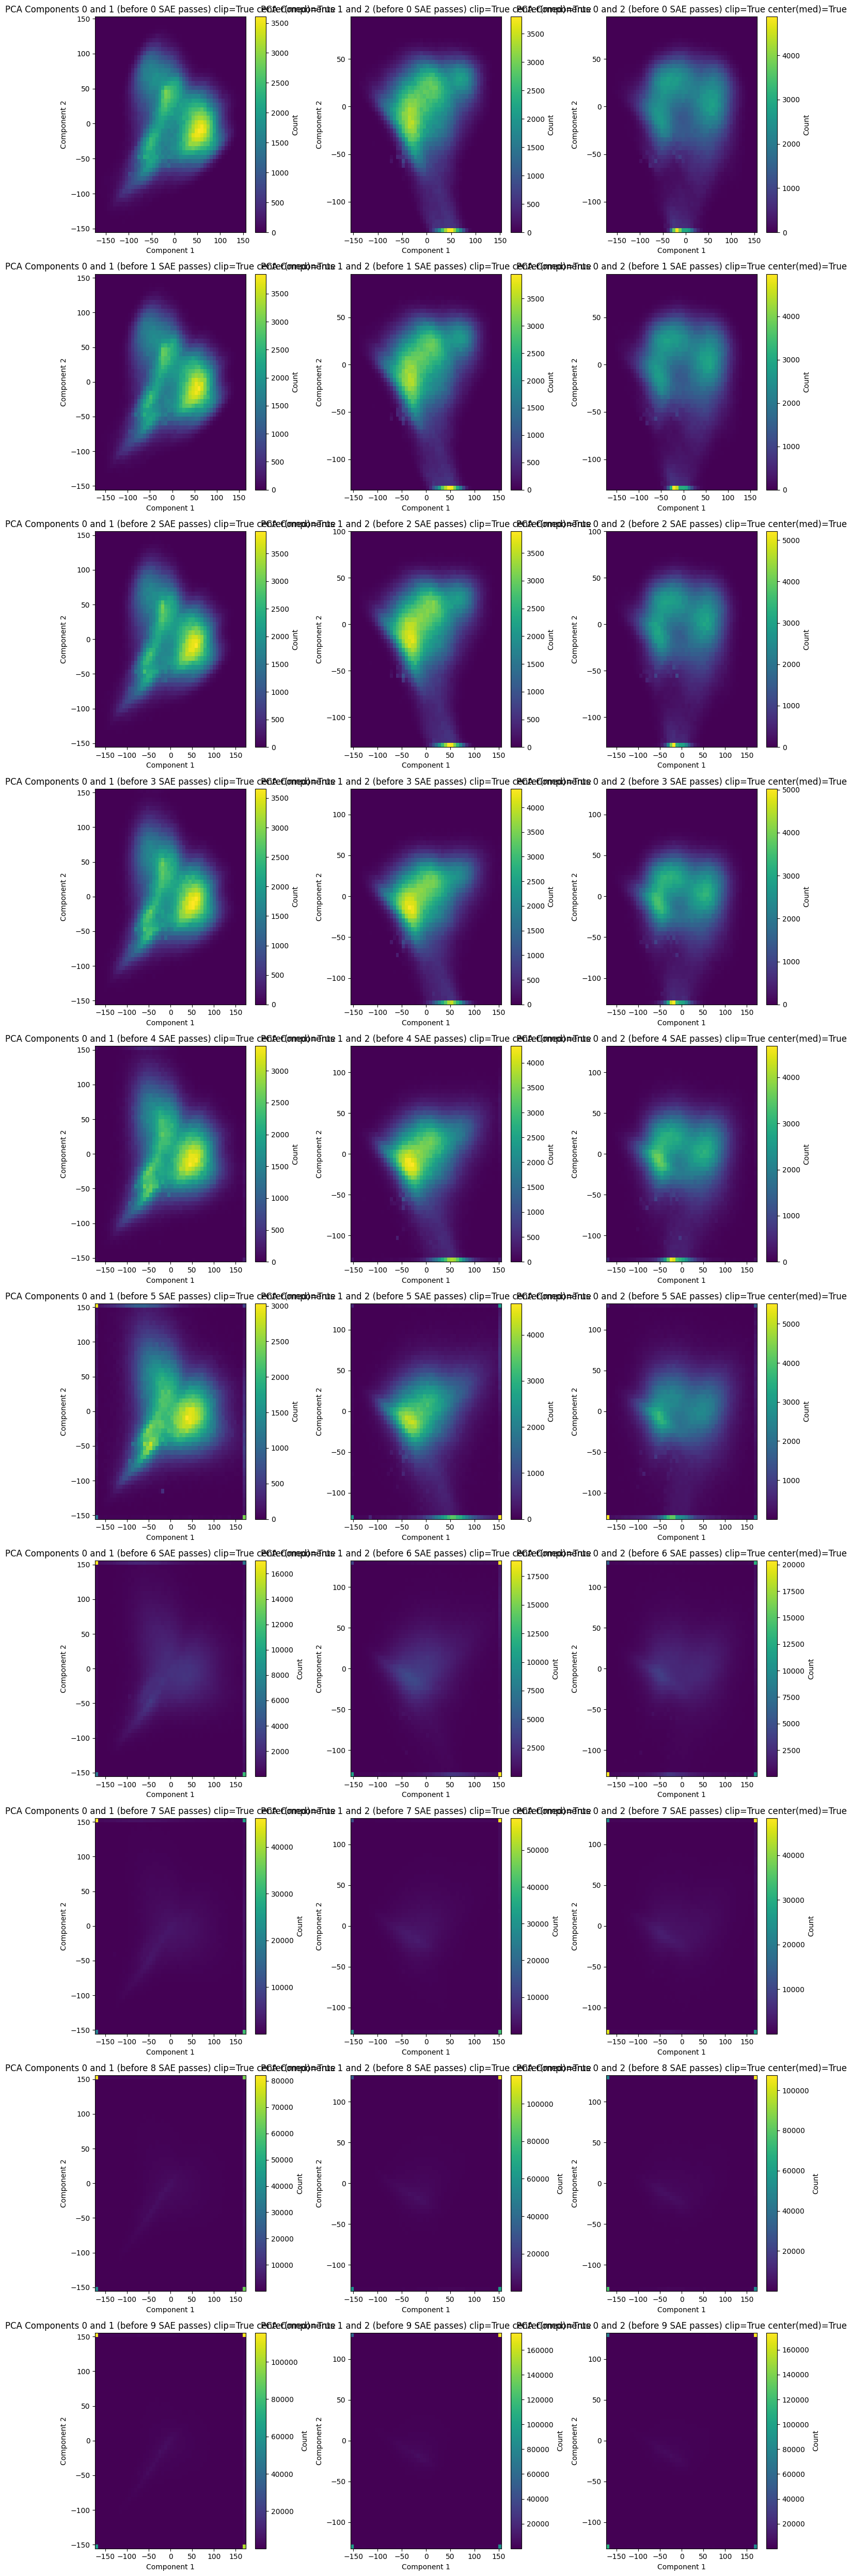

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import pydantic
from typing import Iterator


class AccuracyStats(pydantic.BaseModel):
    mses: List[float]
    mean_fvus: List[float]
    max_fvus: List[float]
    min_fvus: List[float]
    stdev_fvus: List[float]
    median_fvus: List[float]


class SAEApplicationSweeper:
    def __init__(self):
        pass

    def plot_2d_histogram_block(self, data, title, ax, bins=50):
        """By Claude"""
        # Convert to numpy for histogram calculation
        x = data[:, 0].cpu().numpy()
        y = data[:, 1].cpu().numpy()

        # Create 2D histogram
        hist, x_edges, y_edges = np.histogram2d(x, y, bins=bins)

        # Plot as a heatmap
        im = ax.imshow(
            hist.T,
            origin="lower",
            aspect="auto",
            extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
            cmap="viridis",
        )

        plt.colorbar(im, ax=ax, label="Count")
        ax.set_title(title)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")

    def plot_2d_histogram_table(
        self,
        projections_info_iterable: Iterator[
            List[Tuple[Float[Tensor, "n_samples n_components"], str]]
        ],
        n_rows: int,
        n_cols: int,
        clip_histo: bool = True,
        center_at_median: bool = False,
    ):
        """By Claude"""
        # Create a figure with 3 subplots in a row
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
        # Plot 2D histograms for each projection
        x_max, y_max, x_min, y_min = (
            [None for _ in range(n_cols)],
            [None for _ in range(n_cols)],
            [None for _ in range(n_cols)],
            [None for _ in range(n_cols)],
        )
        for iter, projections_info in tqdm.tqdm(enumerate(projections_info_iterable), total=n_rows, desc="Plotting 2D histograms"):
            assert isinstance(projections_info, list)
            assert len(projections_info) == n_cols
            assert iter < n_rows
            for i, (data, title) in enumerate(projections_info):
                # Make sure to initialize to the first iteration viewpoint
                if x_max[i] is None:
                    assert y_max[i] is None and x_min[i] is None and y_min[i] is None
                    x_max[i], y_max[i], x_min[i], y_min[i] = (
                        data[:, 0].max(),
                        data[:, 1].max(),
                        data[:, 0].min(),
                        data[:, 1].min(),
                    )
                if clip_histo and not center_at_median:
                    # Clamp around original viewpoint
                    data = torch.clamp(data, min=x_min[i], max=x_max[i])
                elif clip_histo and center_at_median:
                    # Clamp around median
                    dx, dy = x_max[i] - x_min[i], y_max[i] - y_min[i]
                    x_median, y_median = torch.median(data[:, 0]), torch.median(data[:, 1])
                    data[:, 0] = torch.clamp(data[:, 0], min=x_median - dx/2, max=x_median + dx/2)
                    data[:, 1] = torch.clamp(data[:, 1], min=y_median - dy/2, max=y_median + dy/2)
                elif not clip_histo and center_at_median:
                    x_median, y_median = torch.median(data[:, 0]), torch.median(data[:, 1])
                    data[:, 0] = data[:, 0] - x_median
                    data[:, 1] = data[:, 1] - y_median
                else:
                    pass # do nothing here eh
                title += f" clip={clip_histo} center(med)={center_at_median}"
                self.plot_2d_histogram_block(data, title, axes[iter, i])
            plt.tight_layout()
        plt.show()

    def apply_sae(
        self,
        activations: Float[Tensor, "n_samples n_features"],
        sae: SAE,
        batch_size: int,
    ) -> Float[Tensor, "n_samples n_features"]:
        recons = []
        activations_device = activations.device
        sae_device = next(p.device for p in sae.parameters())
        for i in tqdm.trange(
            0, activations.shape[0], batch_size, desc="SAE forward (application)"
        ):
            j = min(i + batch_size, activations.shape[0])
            activations_batch = activations[i:j]
            activations_batch = activations_batch.to(sae_device)
            recons.append(sae(activations_batch).to(activations_device))
        for r in recons:
            r.cpu() # TODO(Adriano) fking OOM
        recons_pt = torch.cat(recons, dim=0)
        assert recons_pt.shape == activations.shape
        return recons_pt

    def apply_saes_over_k(
        self,
        sae: SAE,
        activations: Float[Tensor, "n_samples n_features"],
        k: int,
        batch_size: int,
        # clip_histo: bool = True, # Just do both yolo
        activations_proj: Float[Tensor, "n_components n_features"] = None,
        activations_val: Float[Tensor, "n_features"] = None,
        activations_mean: Float[Tensor, "n_features"] = None,
    ) -> AccuracyStats:
        assert (
            activations.ndim == 2
        ), f"Expected 2D activations, got {activations.shape}D"
        sae_device = next(p.device for p in sae.parameters())
        activations_so_far = activations.detach().clone().to(sae_device)
        activations_init = activations.detach().clone().to(sae_device)
        # Variances really means the error w.r.t. the mean estimator
        # TODO(Adriano) why do we keep OOMing ugh
        variances = (
            (activations_init - activations_init.mean(dim=0, keepdim=True))
            .pow(2)
            .sum(dim=-1, keepdim=True)
            .cpu()
        )
        # activations_init = activations_init.to(sae_device)
        (activations_proj, activations_val, activations_mean) = (
            activations_proj.to(sae_device),
            activations_val.to(sae_device),
            activations_mean.to(sae_device),
        )
        mses = []
        mean_fvus = []
        max_fvus = []
        min_fvus = []
        stdev_fvus = []
        median_fvus = []
        projections_infos = []
        for k in tqdm.trange(0, 10, desc="SAE passes"):
            # Project and plot
            # TODO(Adriano) support more PCS!
            pca_01 = apply_pca(
                activations_so_far, activations_mean, activations_proj, [0, 1]
            )
            pca_12 = apply_pca(
                activations_so_far, activations_mean, activations_proj, [1, 2]
            )
            pca_02 = apply_pca(
                activations_so_far, activations_mean, activations_proj, [0, 2]
            )
            projections_info = [
                (pca_01, f"PCA Components 0 and 1 (before {k} SAE passes)"),
                (pca_12, f"PCA Components 1 and 2 (before {k} SAE passes)"),
                (pca_02, f"PCA Components 0 and 2 (before {k} SAE passes)"),
            ]
            # self.plot_2d_histogram_row(projections_info)
            projections_infos.append(projections_info)
            # 2. Apply SAE3 xxx make this batchd
            batch_size = 10_000
            activations_so_far = self.apply_sae(activations_so_far.to(sae_device), sae, batch_size)
            # TODO(Adriano) why such OOMing ugh
            mse = (activations_so_far.to(activations_init.device) - activations_init).pow(2).mean().item()
            fvu = (activations_so_far.to(activations_init.device) - activations_init).pow(2).sum(
                dim=-1, keepdim=True
            ).cpu() / variances
            # eh...
            mses.append(mse)
            # Get some FVU statistics
            mean_fvus.append(fvu.mean().item())
            max_fvus.append(fvu.max().item())
            min_fvus.append(fvu.min().item())
            stdev_fvus.append(fvu.std().item())
            median_fvus.append(fvu.median().item())
        # One row per n_pcs
        for clip_histo in [False, True]:
            for center_at_median in [False, True]:
                self.plot_2d_histogram_table(
                    projections_infos, len(projections_infos), 3, clip_histo=clip_histo, center_at_median=center_at_median
                )
        return AccuracyStats(
            mses=mses,
            mean_fvus=mean_fvus,
            max_fvus=max_fvus,
            min_fvus=min_fvus,
            stdev_fvus=stdev_fvus,
            median_fvus=median_fvus,
        )


# ...
import gc
try:
    del model
except NameError:
    print("Model not found (probably already deleted tbh)")
gc.collect()
torch.cuda.empty_cache()
# ...
sweeper = SAEApplicationSweeper()
err_info = sweeper.apply_saes_over_k(
    sae,
    activations,
    k=10,
    batch_size=20_000,
    activations_proj=activations_proj,
    activations_val=activations_val,
    activations_mean=activations_mean,
)

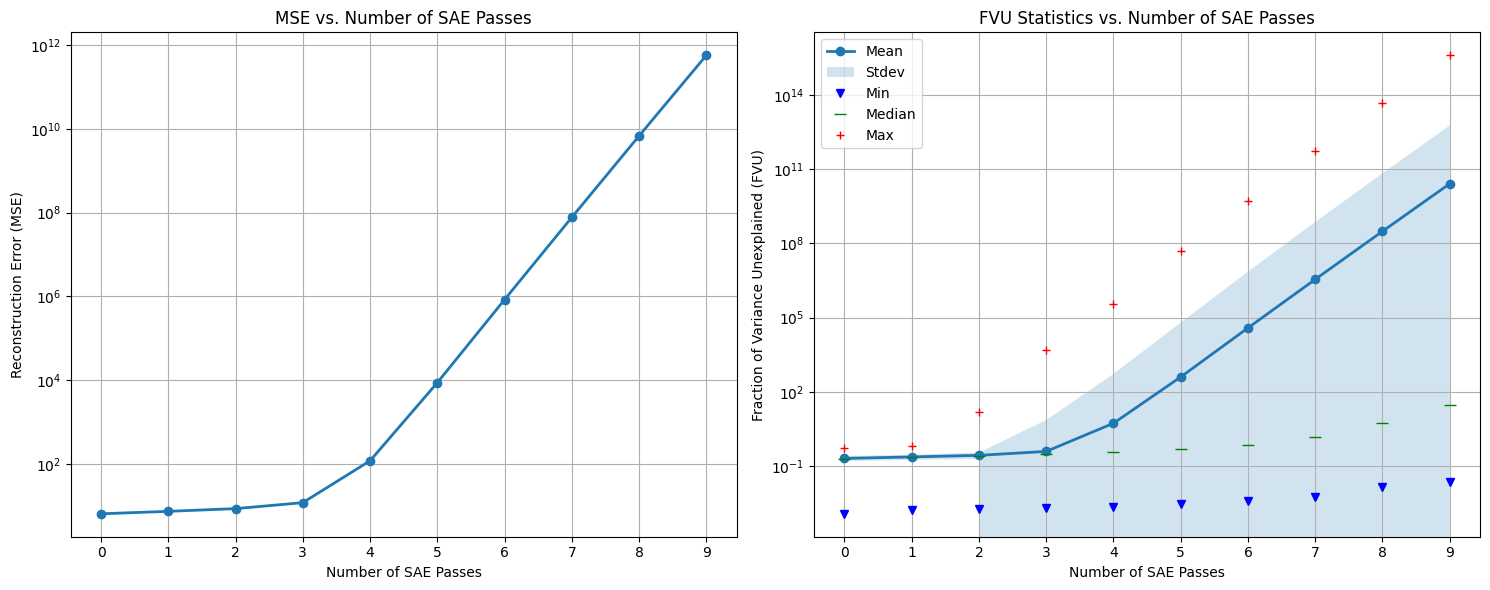

In [22]:
# KEEP THIS
#
# UNCOMMENT TO DEBUG THE VISUALIZATION
#
# import pydantic
# class AccuracyStats(pydantic.BaseModel):
#     mses: List[float]
#     mean_fvus: List[float]
#     max_fvus: List[float]
#     min_fvus: List[float]
#     stdev_fvus: List[float]
#     median_fvus: List[float]
# import random
# # create a random one for testing
# err_info = AccuracyStats(mses=[random.random() for _ in range(10)],
#                           mean_fvus=[random.random() for _ in range(10)],
#                           max_fvus=[10 for _ in range(10)],
#                           min_fvus=[-10 for _ in range(10)],
#                           stdev_fvus=[3+0.01*random.random() for _ in range(10)],
#                           median_fvus=[random.random() for _ in range(10)])

# Plot the reconstruction errors and FVUs over SAE passes
#
# TODO(Adriano) turn this into a standard called function for stats (since we will often)
# want to get a notion of the scaling including distributional information
#
def plot_sae_accuracy_stats(err_info: AccuracyStats, mse_scale_log: bool = False, fvu_scale_log: bool = False):
    """
    Plot the reconstruction errors and FVUs over SAE passes.
    
    Args:
        err_info: AccuracyStats object containing MSEs and FVU statistics
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot MSE
    ax1.plot(
        range(len(err_info.mses)), err_info.mses, marker="o", linestyle="-", linewidth=2
    )
    ax1.set_xlabel("Number of SAE Passes")
    if mse_scale_log:
        ax1.set_yscale("log")
    ax1.set_ylabel("Reconstruction Error (MSE)")
    ax1.set_title("MSE vs. Number of SAE Passes")
    ax1.grid(True)
    ax1.set_xticks(range(len(err_info.mses)))

    # Plot FVUs
    x = range(len(err_info.mean_fvus))
    ax2.plot(
        x, err_info.mean_fvus, marker="o", linestyle="-", linewidth=2, label="Mean FVU"
    )
    # Add shading for standard deviation
    ax2.fill_between(
        x,
        [mean - std for mean, std in zip(err_info.mean_fvus, err_info.stdev_fvus)],
        [mean + std for mean, std in zip(err_info.mean_fvus, err_info.stdev_fvus)],
        alpha=0.2,
    )

    # Add min, median, and max markers
    for i in x:
        # ax2.vlines(i, err_info.min_fvus[i], err_info.max_fvus[i], colors='gray', linestyles='--', alpha=0.5)
        ax2.plot(i, err_info.min_fvus[i], "v", color="blue", markersize=6)
        ax2.plot(i, err_info.median_fvus[i], "_", color="green", markersize=8)
        ax2.plot(i, err_info.max_fvus[i], "+", color="red", markersize=6)

    ax2.set_xlabel("Number of SAE Passes")
    ax2.set_ylabel("Fraction of Variance Unexplained (FVU)")
    ax2.set_title("FVU Statistics vs. Number of SAE Passes")
    ax2.grid(True)
    ax2.set_xticks(range(len(err_info.mean_fvus)))
    ax2.legend(["Mean", "Stdev", "Min", "Median", "Max"])
    if fvu_scale_log: 
        ax2.set_yscale("log")
    plt.tight_layout()
    return fig

# Call the function with our error info
plot_sae_accuracy_stats(err_info)
plt.show()

Analyzing loss with 200 tokens, layer 21, 10 applications
Computing loss across 10 SAE applications...


SAE K=11 passes (incl. 0): 100%|██████████| 11/11 [01:13<00:00,  6.66s/it]

Plotting loss statistics...


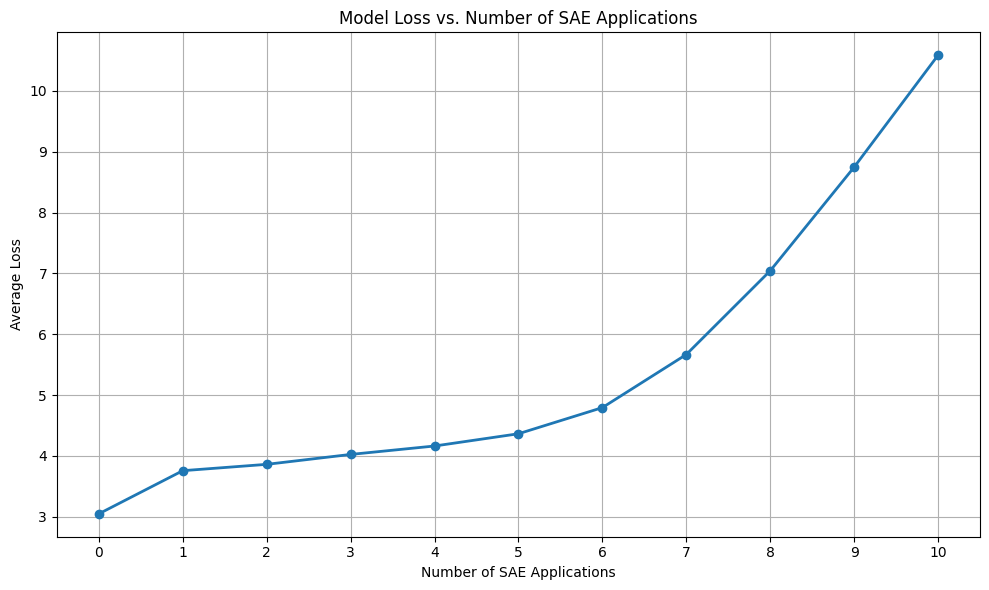

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import pydantic
from typing import List, Optional
from sae_lens import SAE
from torch import Tensor


class LossStats(pydantic.BaseModel):
    """Statistics for model loss across SAE applications."""
    losses: List[float]  # Average loss for each application


class SAELossSweeper:
    def __init__(self):
        """Initialize the SAE Loss Sweeper."""
        pass
    
    def apply_sae_to_layer(
        self, 
        model, 
        sae: SAE, 
        less_tokens: torch.Tensor, 
        layer_idx: int = 20, 
        batch_size: int = 100,
        k: int = 1
    ):
        """
        By Claude
        """
        import gc
        gc.collect()
        torch.cuda.empty_cache()
        
        all_losses = []
        batch_sizes = []
        
        # Function to apply SAE at the specified layer
        def pre_sae_hook(k, mod, inputs):
            # Apply SAE to inputs
            assert isinstance(inputs, tuple)
            sae_device = next(p.device for p in sae.parameters())
            input_tensor = inputs[0].detach().clone().to(sae_device)
            
            # Process in batches to avoid OOM
            for _ in range(k):
                input_tensor = sae(input_tensor)
            input_tensor = input_tensor.to(inputs[0].device)
            
            return (input_tensor,) + inputs[1:]
        
        # Process in batches to collect loss
        handle = model.model.layers[layer_idx].register_forward_pre_hook(lambda mod, inputs: pre_sae_hook(k, mod, inputs))
        try:
            for i in tqdm.trange(0, less_tokens.shape[0], batch_size, desc=f"Collecting loss (batch size = {batch_size})"):
                j = min(i + batch_size, less_tokens.shape[0])
                batch_tokens = less_tokens[i:j].to(model.device)
                
                with torch.no_grad():
                    outputs = model(batch_tokens, labels=batch_tokens)
                    sae_loss = outputs.loss.detach().item()
                    all_losses.append(sae_loss)
                    batch_sizes.append(batch_tokens.shape[0])
        finally:
            handle.remove()
        
        # Get the weighted average
        all_losses = torch.tensor(all_losses).float()
        batch_sizes = torch.tensor(batch_sizes).float()
        batch_sizes /= batch_sizes.sum()
        return (all_losses * batch_sizes).sum()
    
    def compute_loss_across_applications(
        self,
        model,
        sae: SAE,
        tokens: torch.Tensor,
        subset_size: int,
        layer_idx: int,
        num_applications: int,
        batch_size: int,
    ) -> LossStats:
        """
        By Claude
        """
        # Get original loss without any hooks
        less_tokens = tokens[:subset_size]
        losses = []
        print(f"Computing loss across {num_applications} SAE applications...")
        for k in tqdm.trange(0, num_applications + 1, desc=f"SAE K={num_applications+1} passes (incl. 0)"):
            avg_loss = self.apply_sae_to_layer(
                model=model,
                sae=sae,
                less_tokens=less_tokens,
                layer_idx=layer_idx,
                batch_size=batch_size,
                k=k
            )
            
            losses.append(avg_loss)
            
            # Clear memory
            torch.cuda.empty_cache()
        
        return LossStats(losses=losses)
    
    def plot_loss_stats(self, loss_stats: LossStats):
        """
        Plot loss statistics.
        
        Args:
            loss_stats: Loss statistics
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        
        x = range(len(loss_stats.losses))
        ax.plot(x, loss_stats.losses, marker="o", linestyle="-", linewidth=2)
        
        ax.set_xlabel("Number of SAE Applications")
        ax.set_ylabel("Average Loss")
        ax.set_title("Model Loss vs. Number of SAE Applications")
        ax.grid(True)
        ax.set_xticks(range(len(loss_stats.losses)))
        
        plt.tight_layout()
        plt.show()
        
    def run_loss_analysis(
        self, 
        model, 
        tokens, 
        sae: SAE, 
        subset_size: int, 
        layer_idx: int = 20,
        num_applications: int = 10, 
        batch_size: int = 100,
        per_token_stats: bool = False
    ):
        """
        By Claude
        """
        print(f"Analyzing loss with {subset_size} tokens, layer {layer_idx}, {num_applications} applications")
        
        loss_stats = self.compute_loss_across_applications(
            model=model,
            sae=sae,
            tokens=tokens,
            subset_size=subset_size,
            layer_idx=layer_idx,
            num_applications=num_applications,
            batch_size=batch_size
        )
        
        print("Plotting loss statistics...")
        self.plot_loss_stats(loss_stats)
        
        return loss_stats


sweeper = SAELossSweeper()
loss_stats = sweeper.run_loss_analysis(
    model=model,
    tokens=tokens,
    sae=sae,
    subset_size=200, # Don't OOM plz tyty
    layer_idx=21, # NOTE: we use a pre-hook and this was for post layer 20 AFAIK
    num_applications=10,
    batch_size=100
)